In [1]:

!pip install evaluate torch transformers datasets scikit-learn tqdm peft bitsandbytes accelerate --quiet

!pip install -U datasets huggingface-hub fsspec --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 82.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.1/76.1 MB 15.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 13.4 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cesium 0.12.4 requires numpy

In [2]:
import os
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from datasets import load_dataset
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from transformers import (
    T5EncoderModel,
    T5TokenizerFast,
    get_linear_schedule_with_warmup,
    BitsAndBytesConfig
)
from peft import (
    LoraConfig,
    get_peft_model,
    TaskType,
    prepare_model_for_kbit_training
)
import torch.nn as nn
import evaluate

2025-05-21 17:55:54.324337: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747850154.490562      18 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747850154.544672      18 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
SEED = 42
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [4]:
# Configure 4-bit quantization for QLoRA
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)


In [5]:
# Load tokenizer
tokenizer = T5TokenizerFast.from_pretrained('t5-small')
print("Tokenizer loaded")

tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

Tokenizer loaded


### Dataset Loader

In [6]:
class SQuADDataset(Dataset):
    def __init__(self, data, tokenizer, max_length=512):
        self.data = data
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        item = self.data[index]
        question = item['question']
        context = item['context']
        answers = item['answers']

        # Direct concatenation without prompting
        input_text = f"{question} {context}"

        encoding = self.tokenizer(
            input_text,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt',
            return_offsets_mapping=True
        )

        # Get offset mapping and remove it from encoding
        offset_mapping = encoding.pop('offset_mapping').squeeze()

        # Find answer positions by searching in the concatenated text
        answer_text = answers['text'][0] if answers['text'] else ""

        # We need to find the answer in the context part, not the question part
        # So we search starting from after the question
        question_len = len(question) + 1  # +1 for the space separator
        context_start_in_input = question_len

        # Find answer in context portion of input_text
        answer_start_in_context = context.find(answer_text) if answer_text else -1
        answer_start_char = context_start_in_input + answer_start_in_context if answer_start_in_context != -1 else -1

        start_position = 0
        end_position = 0

        if answer_start_char != -1 and answer_text:
            answer_end_char = answer_start_char + len(answer_text)

            # Find token positions
            for idx, (start_offset, end_offset) in enumerate(offset_mapping):
                if start_offset <= answer_start_char < end_offset:
                    start_position = idx
                if start_offset < answer_end_char <= end_offset:
                    end_position = idx
                    break

        return {
            'input_ids': encoding['input_ids'].squeeze(),
            'attention_mask': encoding['attention_mask'].squeeze(),
            'start_positions': torch.tensor(start_position, dtype=torch.long),
            'end_positions': torch.tensor(end_position, dtype=torch.long),
            'example_id': item.get('id', index)
        }

In [7]:
dataset = load_dataset("rajpurkar/squad")

train_subset = dataset['train']
test_subset = dataset['validation']
print(f"Training on {len(train_subset)} samples, testing on {len(test_subset)} samples")

# Create datasets
train_dataset = SQuADDataset(train_subset, tokenizer)
test_dataset = SQuADDataset(test_subset, tokenizer)

# Create dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)  # Reduced batch size for QLoRA
test_dataloader = DataLoader(test_dataset, batch_size=8)
print("Dataloaders created")

README.md:   0%|          | 0.00/7.62k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/14.5M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/1.82M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/87599 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/10570 [00:00<?, ? examples/s]

Training on 87599 samples, testing on 10570 samples
Dataloaders created


### Model

In [8]:
# Define the QLoRA T5 Encoder QA classifier
class T5EncoderQAWithQLoRA(nn.Module):
    def __init__(self, model_name='t5-small'):
        super().__init__()

        # Load T5 encoder model with 4-bit quantization
        self.t5 = T5EncoderModel.from_pretrained(
            model_name,
            quantization_config=bnb_config,
            device_map="auto",
            torch_dtype=torch.bfloat16
        )

        # Prepare model for k-bit training (required for QLoRA)
        self.t5 = prepare_model_for_kbit_training(self.t5)

        # Configure QLoRA
        peft_config = LoraConfig(
            task_type=TaskType.FEATURE_EXTRACTION,
            inference_mode=False,
            r=16,  # Rank of the low-rank matrices
            lora_alpha=32,  # Scaling factor
            lora_dropout=0.1,  # Dropout for LoRA layers
            target_modules=["q", "v", "k", "o", "wi_0", "wi_1"],  # T5 encoder modules
            bias="none",
            use_rslora=False,  # Use regular LoRA scaling
        )

        # Apply QLoRA to the model
        self.t5 = get_peft_model(self.t5, peft_config)

        # QA heads - these remain in full precision
        self.dropout = nn.Dropout(0.2)
        self.start_head = nn.Linear(self.t5.config.d_model, 1)
        self.end_head = nn.Linear(self.t5.config.d_model, 1)

        # Move QA heads to device
        self.dropout = self.dropout.to(device)
        self.start_head = self.start_head.to(device)
        self.end_head = self.end_head.to(device)

        # Print trainable parameters
        self.t5.print_trainable_parameters()

    def forward(self, input_ids, attention_mask, start_positions=None, end_positions=None):
        # Get encoder outputs
        outputs = self.t5(input_ids=input_ids, attention_mask=attention_mask)

        # Get the last hidden states
        sequence_output = outputs.last_hidden_state
        sequence_output = self.dropout(sequence_output)

        # Compute start and end logits
        start_logits = self.start_head(sequence_output).squeeze(-1)
        end_logits = self.end_head(sequence_output).squeeze(-1)

        # Apply attention mask to logits
        if attention_mask is not None:
            attention_mask = attention_mask.float()
            start_logits = start_logits + (1.0 - attention_mask) * -10000.0
            end_logits = end_logits + (1.0 - attention_mask) * -10000.0

        loss = None
        if start_positions is not None and end_positions is not None:
            loss_fct = nn.CrossEntropyLoss()
            start_loss = loss_fct(start_logits, start_positions)
            end_loss = loss_fct(end_logits, end_positions)
            loss = (start_loss + end_loss) / 2

        return {
            'loss': loss,
            'start_logits': start_logits,
            'end_logits': end_logits
        }

In [9]:
# Initialize the model
print("Initializing QLoRA model...")
model = T5EncoderQAWithQLoRA()
print("Model initialized with 4-bit quantization")


Initializing QLoRA model...


config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

trainable params: 393,216 || all params: 35,724,032 || trainable%: 1.1007
Model initialized with 4-bit quantization


### Training and evaluating

In [10]:
# Training function with gradient accumulation for QLoRA
def train_epoch(model, dataloader, optimizer, scheduler, device, gradient_accumulation_steps=4):
    model.train()
    total_loss = 0
    start_predictions = []
    end_predictions = []
    start_labels = []
    end_labels = []

    progress_bar = tqdm(dataloader, desc="Training")
    optimizer.zero_grad()

    for step, batch in enumerate(progress_bar):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        start_positions = batch['start_positions'].to(device)
        end_positions = batch['end_positions'].to(device)

        outputs = model(input_ids, attention_mask, start_positions, end_positions)
        loss = outputs['loss']

        # Scale loss by gradient accumulation steps
        loss = loss / gradient_accumulation_steps
        loss.backward()

        total_loss += loss.item() * gradient_accumulation_steps

        # Get predictions for metrics
        start_preds = torch.argmax(outputs['start_logits'], dim=1)
        end_preds = torch.argmax(outputs['end_logits'], dim=1)

        start_predictions.extend(start_preds.cpu().tolist())
        end_predictions.extend(end_preds.cpu().tolist())
        start_labels.extend(start_positions.cpu().tolist())
        end_labels.extend(end_positions.cpu().tolist())

        # Update optimizer every gradient_accumulation_steps
        if (step + 1) % gradient_accumulation_steps == 0 or (step + 1) == len(dataloader):
            # Clip gradients for stability with quantized models
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            scheduler.step()
            optimizer.zero_grad()

        # Update progress bar
        progress_bar.set_postfix({'loss': loss.item() * gradient_accumulation_steps})

    # Calculate accuracy
    start_accuracy = np.mean(np.array(start_predictions) == np.array(start_labels))
    end_accuracy = np.mean(np.array(end_predictions) == np.array(end_labels))
    avg_loss = total_loss / len(dataloader)

    return avg_loss, start_accuracy, end_accuracy

In [11]:
# Evaluation function
def evaluating(model, dataloader, device, tokenizer):
    model.eval()
    total_loss = 0
    predictions = []

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            start_positions = batch['start_positions'].to(device)
            end_positions = batch['end_positions'].to(device)

            outputs = model(input_ids, attention_mask, start_positions, end_positions)
            loss = outputs['loss']
            total_loss += loss.item()

            # Get span predictions
            start_preds = torch.argmax(outputs['start_logits'], dim=1)
            end_preds = torch.argmax(outputs['end_logits'], dim=1)

            # Decode predictions to text
            for i in range(len(input_ids)):
                start_idx = start_preds[i].item()
                end_idx = end_preds[i].item()

                # Ensure valid span
                if end_idx < start_idx:
                    end_idx = start_idx

                # Extract answer text
                answer_tokens = input_ids[i][start_idx:end_idx+1]
                pred_text = tokenizer.decode(answer_tokens, skip_special_tokens=True).strip()

                predictions.append(pred_text)

    avg_loss = total_loss / len(dataloader)
    return avg_loss, predictions

In [12]:
# Set up optimizer and scheduler with lower learning rate for QLoRA
num_epochs = 5
learning_rate = 1e-4  # Lower learning rate for QLoRA

# Only optimize trainable parameters (LoRA adapters + QA heads)
trainable_params = [p for p in model.parameters() if p.requires_grad]
optimizer = AdamW(trainable_params, lr=learning_rate, weight_decay=0.01)

total_steps = len(train_dataloader) * num_epochs
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=int(0.1 * total_steps),
    num_training_steps=total_steps
)
print("Optimizer and scheduler configured for QLoRA")

Optimizer and scheduler configured for QLoRA


In [13]:
# Initialize tracking variables
train_losses = []
train_start_accs = []
train_end_accs = []
val_losses = []
best_val_loss = float('inf')


In [14]:
# Plotting function for training metrics
def plot_training_history(train_losses, train_start_accs, train_end_accs, val_losses):
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.plot(train_losses, label='Training Loss', marker='o')
    plt.plot(val_losses, label='Validation Loss', marker='s')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss (QLoRA)')
    plt.grid(True, alpha=0.3)

    plt.subplot(1, 3, 2)
    plt.plot(train_start_accs, label='Start Position Accuracy', marker='o')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Start Position Accuracy (QLoRA)')
    plt.grid(True, alpha=0.3)

    plt.subplot(1, 3, 3)
    plt.plot(train_end_accs, label='End Position Accuracy', marker='o')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('End Position Accuracy (QLoRA)')
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('qa_qlora_training_history.png', dpi=300, bbox_inches='tight')
    plt.show()


In [15]:
print("Starting QLoRA training...")
for epoch in range(num_epochs):
    print(f"\nEpoch {epoch + 1}/{num_epochs}")

    # Train
    train_loss, start_acc, end_acc = train_epoch(
        model, train_dataloader, optimizer, scheduler, device, gradient_accumulation_steps=4
    )
    train_losses.append(train_loss)
    train_start_accs.append(start_acc)
    train_end_accs.append(end_acc)

    # Evaluate
    val_loss, predictions = evaluating(model, test_dataloader, device, tokenizer)
    val_losses.append(val_loss)

    print(f"Train Loss: {train_loss:.4f}, Start Acc: {start_acc:.4f}, End Acc: {end_acc:.4f}")
    print(f"Val Loss: {val_loss:.4f}")
    print(f"Memory usage: {torch.cuda.memory_allocated() / 1024**3:.2f} GB")

    # Save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        # Save only the LoRA adapters (much smaller)
        model.t5.save_pretrained('best_qlora_t5_encoder_qa_adapters')
        torch.save({
            'start_head': model.start_head.state_dict(),
            'end_head': model.end_head.state_dict(),
            'dropout': model.dropout.state_dict()
        }, 'best_qlora_t5_encoder_qa_heads.pth')
        print(f"New best model saved with validation loss: {val_loss:.4f}")

Starting QLoRA training...

Epoch 1/5


Training:   0%|          | 0/10950 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/_dynamo/eval_frame.py:745: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
Evaluating: 100%|██████████| 1322/1322 [01:50<00:00, 11.94it/s]


Train Loss: 4.1234, Start Acc: 0.1465, End Acc: 0.1270
Val Loss: 2.2385
Memory usage: 0.11 GB
New best model saved with validation loss: 2.2385

Epoch 2/5


Evaluating: 100%|██████████| 1322/1322 [01:51<00:00, 11.87it/s]


Train Loss: 1.9537, Start Acc: 0.5003, End Acc: 0.4917
Val Loss: 1.4492
Memory usage: 0.11 GB
New best model saved with validation loss: 1.4492

Epoch 3/5


Evaluating: 100%|██████████| 1322/1322 [01:51<00:00, 11.84it/s]


Train Loss: 1.5355, Start Acc: 0.5815, End Acc: 0.5876
Val Loss: 1.3481
Memory usage: 0.11 GB
New best model saved with validation loss: 1.3481

Epoch 4/5


Evaluating: 100%|██████████| 1322/1322 [01:51<00:00, 11.84it/s]


Train Loss: 1.4323, Start Acc: 0.5992, End Acc: 0.6101
Val Loss: 1.2970
Memory usage: 0.11 GB
New best model saved with validation loss: 1.2970

Epoch 5/5


Evaluating: 100%|██████████| 1322/1322 [01:51<00:00, 11.87it/s]


Train Loss: 1.3756, Start Acc: 0.6097, End Acc: 0.6235
Val Loss: 1.2754
Memory usage: 0.11 GB
New best model saved with validation loss: 1.2754


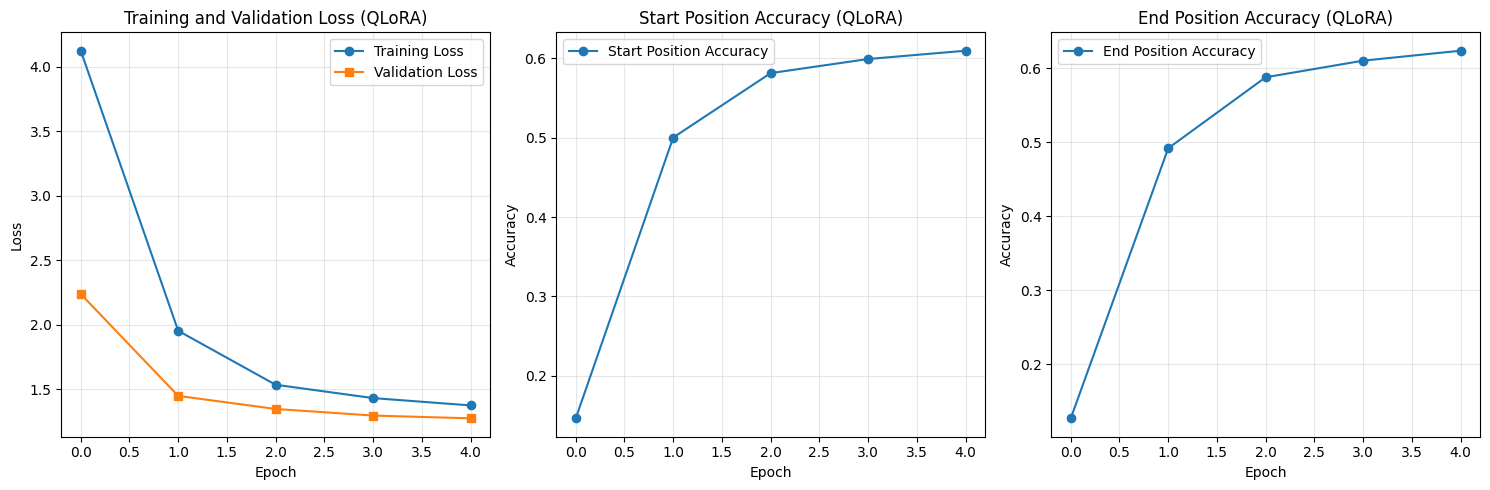

In [16]:
# Plot training history
plot_training_history(train_losses, train_start_accs, train_end_accs, val_losses)

In [17]:
# Load best LoRA adapters
model.t5.load_adapter('best_qlora_t5_encoder_qa_adapters',adapter_name='best_qlora_adapter')
qa_heads = torch.load('best_qlora_t5_encoder_qa_heads.pth')
model.start_head.load_state_dict(qa_heads['start_head'])
model.end_head.load_state_dict(qa_heads['end_head'])
model.dropout.load_state_dict(qa_heads['dropout'])

_, final_predictions = evaluating(model, test_dataloader, device, tokenizer)

Evaluating: 100%|██████████| 1322/1322 [01:50<00:00, 11.93it/s]


In [18]:
# Compute SQuAD metrics
squad_metric = evaluate.load("squad")

# Format predictions for SQuAD evaluation
formatted_predictions = []
formatted_references = []

for i, pred in enumerate(final_predictions):
    example = test_subset[i]
    formatted_predictions.append({
        "id": str(i),
        "prediction_text": pred
    })
    formatted_references.append({
        "id": str(i),
        "answers": {
            "text": example['answers']['text'],
            "answer_start": example['answers']['answer_start']
        }
    })

# Compute final metrics
results = squad_metric.compute(predictions=formatted_predictions, references=formatted_references)
print(f"\nFinal SQuAD Metrics (QLoRA):")
print(f"Exact Match: {results['exact_match']:.4f}")
print(f"F1 Score: {results['f1']:.4f}")


Final SQuAD Metrics (QLoRA):
Exact Match: 69.2148
F1 Score: 79.1966
